In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import importlib

from pathlib import Path

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interpolate

import project_path
import nn.utils as utils
import nn.model.net as net
import nn.model.data as data
data = importlib.reload(data)
import nn.model.loss as loss

## Constants

In [2]:
NUM_CLASSES = 5
CLASSES = ['Gluon', 'Lght quarks', 'W boson', 'Z boson', 'Top quark']
MODEL_DIR = Path("../../experiments/constituent_base/best.script.pth")

In [3]:
torch.manual_seed(230)

## Data

In [4]:
# (1) creating dataset
datasets = data.get_dataset(splits=['train-val', 'test'])
dataset = datasets['train-val']
test_set = datasets['test']

# print(dataset[0])

# (2) train-validation split
dataset_size = len(dataset)
print("dataset_size: ", dataset_size)
train_set, val_set, _ = torch.utils.data.random_split(dataset, [dataset_size - 1000, 1000, 0])

# (3) train-validation dataloaders
train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=data.get_collate_fn())
val_loader = data.DataLoader(val_set, batch_size=32, collate_fn=data.get_collate_fn())
test_loader = data.DataLoader(test_set, batch_size=32, collate_fn=data.get_collate_fn())

print("val_loader size:", len(val_loader))

# print("First value of val_loader:")
# print(next(next(iter(val_loader))))

print(type(dataset))
print(type(test_set))
print(type(train_set))
print(type(val_set))

dataset_size:  80000
val_loader size: 32
<class 'nn.model.data.JetDataset'>
<class 'nn.model.data.JetDataset'>
<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


## Model

In [5]:
model = torch.jit.load(MODEL_DIR, map_location='cpu')
print(f'Number of parameters: {utils.count_parameters(model)}')
model.eval()

Number of parameters: 399877


RecursiveScriptModule(
  original_name=ConstituentNet
  (inp_layer): RecursiveScriptModule(original_name=Linear)
  (out_layer_0): RecursiveScriptModule(original_name=LayerNorm)
  (out_layer_1): RecursiveScriptModule(original_name=Linear)
  (transformers): RecursiveScriptModule(
    original_name=ModuleList
    (0): RecursiveScriptModule(
      original_name=Transformer
      (self_attention): RecursiveScriptModule(
        original_name=SelfAttention
        (norm): RecursiveScriptModule(original_name=LayerNorm)
        (qkv): RecursiveScriptModule(original_name=Linear)
        (out): RecursiveScriptModule(original_name=Linear)
      )
      (linear_0): RecursiveScriptModule(original_name=LayerNorm)
      (linear_1): RecursiveScriptModule(original_name=SiLU)
      (linear_2): RecursiveScriptModule(original_name=Linear)
      (linear_3): RecursiveScriptModule(original_name=LayerNorm)
      (linear_4): RecursiveScriptModule(original_name=SiLU)
      (linear_5): RecursiveScriptModule(orig

## Evaluation

In [6]:
def print_like_HLS(arr):
  print(' '.join('\n' * (n % 129 == 128) + str(el) for n, el in enumerate(arr.transpose().flatten().ravel().tolist())))

def direct_evaluate_sample(sample, model, samples_range=None):
  if samples_range is None:
    samples_range = (0, 1)

  example_sample = sample
  example_data = example_sample.input_seq[samples_range[0]:samples_range[1],:] # get [N particles, all 16 dims]
  print('Input data formatted for HLS:')
  print_like_HLS(example_data)
  print('Input data:')
  print(example_data)
  print()

  example_data = np.expand_dims(example_data, axis=0) # expand batch dim
  print("Example data:")
  print(type(example_data))
  print(example_data.shape)
  print(example_data.dtype)
  print(len(example_data))
  print(example_data)

  example_tensor = torch.from_numpy(example_data)
  # print(type(example_tensor))
  # print(example_tensor.shape)
  # print(len(example_tensor))
  # print(example_tensor)

  model = model.double()
  output = model(example_tensor.double())
  # print(output)
  # print(torch.argmax(output).item())
  # print(example_sample.target)
  return torch.argmax(output).item() == example_sample.target

def direct_evaluate_model(dataset, model, samples_range=None, count=10):
  results = []
  for index, sample in tqdm(enumerate(dataset)):
    if index < count:
      results.append(direct_evaluate_sample(sample, model, samples_range))
    else:
      break
  return results

def direct_evaluate_metrics(dataset, model, samples_range=None, count=None):
  count = len(dataset) if count is None else count
  results = direct_evaluate_model(dataset, model, samples_range, count)

  accuracy = sum(el is True for el in results) / len(results)

  # print("All results:")
  # print(results)
  print("Accuracy: " + str(round(accuracy*100, 2)) + "%")

In [8]:
from torchsummary import summary

# print(len(dataset))

# print(len(test_set))
# print(type(test_set[0]))
torch.set_printoptions(profile='full', sci_mode=False, threshold=2097152)
# print(model)
direct_evaluate_metrics(test_set, model, samples_range=(0, 1), count=1)
torch.set_printoptions(profile=None, sci_mode=None, threshold=None)
# print(type(test_set[0].input_seq))
# print(test_set[0].input_seq.shape)
# print(type(model))
# summary(model, (1, 100, 16))


1it [00:00,  8.81it/s]

Input data formatted for HLS:
29.938385009765625 178.55862426757812 -67.51207733154297 193.2311248779297 0.17523084580898285 181.0510711669922 0.1761978417634964 -0.3647479712963104 0.008448980748653412 -0.0 1.4046745300292969 0.000455104949651286 0.0 0.008461219258606434 -0.34938931465148926 6.123234262925839e-17
Input data:
[[ 2.99383850e+01  1.78558624e+02 -6.75120773e+01  1.93231125e+02
   1.75230846e-01  1.81051071e+02  1.76197842e-01 -3.64747971e-01
   8.44898075e-03 -0.00000000e+00  1.40467453e+00  4.55104950e-04
   0.00000000e+00  8.46121926e-03 -3.49389315e-01  6.12323426e-17]]

Example data:
<class 'numpy.ndarray'>
(1, 1, 16)
float64
1
[[[ 2.99383850e+01  1.78558624e+02 -6.75120773e+01  1.93231125e+02
    1.75230846e-01  1.81051071e+02  1.76197842e-01 -3.64747971e-01
    8.44898075e-03 -0.00000000e+00  1.40467453e+00  4.55104950e-04
    0.00000000e+00  8.46121926e-03 -3.49389315e-01  6.12323426e-17]]]
x.size()
[1, 1, 16]
input -> [1, 1, 16]
(1,.,.) = 
 Columns 1 to 7   29.938

In [18]:
# Statistics summary
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
# with tqdm(total=len(val_loader), unit="batch") as t:
    # print("Before for loop, total={}, unit={}".format(len(val_loader), "batch"))
    # for batch in val_loader:
        # Unpack batch, move to device
        # print("Unpacking batch")
        # input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        # input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        # input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        # targets = batch['targets']        # torch.tensor (n, )

        # # Forward pass
        # print("Forward pass")
        # outputs = model(input_seqs)                 # torch.tensor (n, num_classes)

        # # Append model preds and targs
        # outs_list.append(outputs.detach().numpy())
        # targs_list.append(targets.numpy())

        # # Update tqdm
        # t.update()

with tqdm(total=len(test_set), unit="sample") as t:
    for sample in test_set:
        input_seqs = sample.input_seq  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = sample.input_1d    # torch.tensor (n, 59-6)
        input_2ds = sample.input_2d    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = sample.target        # torch.tensor (n, )

        # Forward pass
        # print("Forward pass")
        input_seqs = np.expand_dims(input_seqs, axis=0)
        input_seqs = torch.from_numpy(input_seqs)
        model = model.double()
        outputs = model(input_seqs.double())                 # torch.tensor (n, num_classes)

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets)

        # Update tqdm
        t.update()


100%|██████████| 20000/20000 [01:11<00:00, 278.91batch/s]


### Confusion Matrix

Accuracy:  0.8342


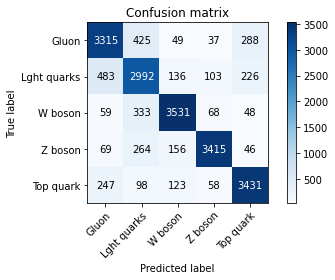

In [19]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, precision,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [20]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

ValueError: unknown format is not supported

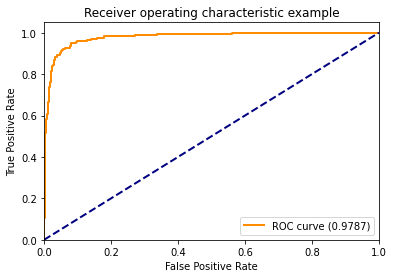

In [10]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [21]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%


KeyError: 0

## Test

In [9]:
# Loss
criterion = torch.nn.NLLLoss()

# Statistics summary
loss_avg = utils.RunningAverage()
summ = []
outs_list = []
targs_list = []

# compute metrics over the dataset
with tqdm(total=len(test_loader), unit="batch") as t:
    for i, batch in enumerate(test_loader):

        # Unpack batch, move to device
        input_seqs = batch['input_seqs']  # torch.tensor (n, 100, 16) - the first 100 highest-$p_T$ particles are considered for each jet
        input_1ds = batch['input_1ds']    # torch.tensor (n, 59-6)
        input_2ds = batch['input_2ds']    # torch.tensor (n, 100, 100, 3) - merge of three jet images
        targets = batch['targets']        # torch.tensor (n, )

        # Forward pass
        outputs = model(input_seqs)                 # torch.tensor (n, num_classes)
        
        # Calculate Loss
        loss = criterion(outputs, targets)
        loss_avg.update(loss.item())

        # Append model preds and targs
        outs_list.append(outputs.detach().numpy())
        targs_list.append(targets.numpy())

        # Update tqdm
        t.update()

  0%|          | 0/625 [00:00<?, ?batch/s]

### Confusion Matrix

Accuracy:  0.8298
Loss:  0.49274327974921217


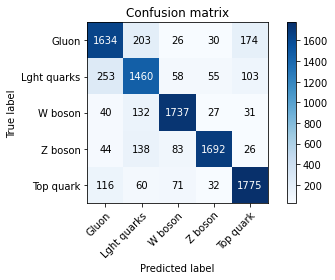

In [7]:
# Stack a list
preds = np.hstack([outs.argmax(axis=-1) for outs in outs_list]) # 1d array of shape (num_samples, )
targs =  np.hstack(targs_list)

# Cofusion Matrix
cm = utils.confusion_matrix(preds, targs)

# Acc, Loss,
print("Accuracy: ",  np.sum(preds == targs) / len(targs))
print("Loss: ", loss_avg())

# Plot confusion matrix
utils.plot_confusion_matrix(cm, CLASSES)
plt.show()

### ROC

In [8]:
# Stack a list of ndarray
y_test = np.vstack([utils.one_hot(targs, NUM_CLASSES) for targs in targs_list])
y_score = np.vstack(outs_list)

# Compute ROC curve and ROC area for each class
fprs = dict()
tprs = dict()
roc_aucs = dict()
for i in range(NUM_CLASSES):
    fprs[i], tprs[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_aucs[i] = auc(fprs[i], tprs[i])

# Compute micro-average of all classes ROC curve and ROC area
fprs["micro"], tprs["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_aucs["micro"] = auc(fprs["micro"], tprs["micro"])

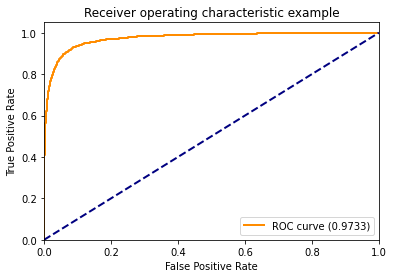

In [9]:
plt.figure()
plt.plot(fprs[4], tprs[4], color='darkorange', lw=2, label=f'ROC curve ({roc_aucs[4]:0.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [10]:
print('TPR for FPR = 10%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.1):<15}')

print()
print('TPR for FPR = 1%')
for i in range(NUM_CLASSES):
    tpr_fpr_intrp = interpolate.interp1d(fprs[i], tprs[i])
    print(f' {CLASSES[i] + ":" :<12} {tpr_fpr_intrp(0.01):<15}')

TPR for FPR = 10%
 Gluon:       0.8746976294146106
 Lght quarks: 0.8252980819077242
 W boson:     0.9527198779867819
 Z boson:     0.9213313161875946
 Top quark:   0.9371957156767283

TPR for FPR = 1%
 Gluon:       0.4833091436865022
 Lght quarks: 0.3048211508553655
 W boson:     0.7646161667513981
 Z boson:     0.8265254664649521
 Top quark:   0.6796494644595911


In [11]:
print(roc_aucs)

{0: 0.9577932284966908, 1: 0.9409424869061572, 2: 0.9819742038924212, 3: 0.9759068774114713, 4: 0.9733401899040528, 'micro': 0.9685415200000002}
